In this code we demonstrate a version of knowledge distillation called feature distillation. The idea comes from a paper: A Simple and Generic Framework for Feature Distillation via Channel-wise Transformation
 by Ziwei Liu, Yongtao Wang, and Xiaojie Chu (https://arxiv.org/abs/2303.13212).

# Knowledge Distillation using Teacher and Student ResNets

In this project, we perform **knowledge distillation** from a large, high-capacity teacher network to a smaller, more efficient student network. The goal is for the student network to mimic both the final predictions and internal representations of the teacher.

## Teacher Model

We use a large pretrained ResNet (e.g., **ResNet-152**) as our **teacher**. The teacher network produces:

- **Final logits:** The output predictions over the classes.
- **Intermediate features:** A pooled feature vector extracted from the output of its **second residual block**.

In mathematical terms, for an input image $x$, the teacher produces:
$$
\textbf{T}_{\text{logits}} = f_{\text{teacher}}(x)
$$
and an intermediate representation
$$
\textbf{T}_{\text{feat}} = g_{\text{teacher}}(x)
$$

## Student Model

The **student** is a smaller ResNet (e.g., **ResNet-18**) that is modified for improved learning via knowledge distillation. The student network is augmented by attaching an **additional branch** to its second residual block. This branch consists of two linear layers with a ReLU activation in between. The student network now produces:

1. **Main logits:** 
   $$
   \textbf{S}_{\text{logits}} = f_{\text{student}}(x)
   $$
2. **Auxiliary output:** A secondary output that comes from the extra branch applied to the pooled features from the second residual block:
   $$
   \textbf{S}_{\text{aux}} = h_{\text{student}}(g_{\text{student}}(x))
   $$

The overall output of the student model is the concatenation of $\textbf{S}_{\text{logits}}$ and $\textbf{S}_{\text{aux}}$, i.e.,
$$
\textbf{S}_{\text{output}} = \left[ \textbf{S}_{\text{logits}}, \; \textbf{S}_{\text{aux}} \right]
$$

## Distillation Loss

During training, the student network is optimized to minimize the discrepancy between its outputs and those of the teacher. We use a combined Mean Squared Error (MSE) loss:

1. **Logit Loss:**
   $$
   L_{\text{logits}} = \left\| \textbf{S}_{\text{logits}} - \textbf{T}_{\text{logits}} \right\|^2
   $$

2. **Feature Loss:**
   $$
   L_{\text{feat}} = \left\| \textbf{S}_{\text{aux}} - \textbf{T}_{\text{feat}} \right\|^2
   $$

The total loss is given by:
$$
L_{\text{total}} = L_{\text{logits}} + L_{\text{feat}}
$$

## Data Generation using BigGAN

To supply diverse training inputs, we generate images using BigGAN. BigGAN is used to create a synthetic dataset that the teacher and student use during training. This approach provides a rich set of images that can help the student learn from the teacher.

## Summary

- **Teacher:** A large ResNet (e.g., ResNet-152) produces both final logits and intermediate features from its second residual block.
- **Student:** A smaller ResNet (e.g., ResNet-18) augmented with an extra branch attached to its second residual block. The extra branch outputs auxiliary features to mimic the teacher's internal representations.
- **Loss:** The student is trained to minimize the combined MSE loss between its logits and the teacher’s logits, and between its auxiliary features and the teacher's intermediate features.
- **Data:** BigGAN is used to generate synthetic images, ensuring the distillation process sees a wide variety of inputs.

This approach aims to transfer the knowledge from a large, computationally expensive model to a compact model that is faster for inference while preserving accuracy.

---


First we get Big-Gan to work.

Loading BigGAN-deep-256 from Hugging Face...


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/pytorch_pretrained_biggan/model.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(reso

Image saved as generated_image.png


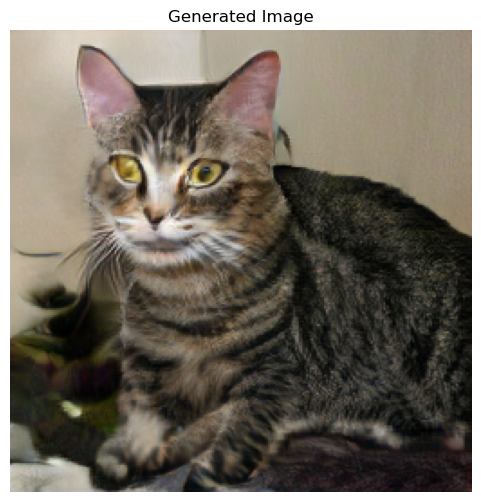

In [1]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from pytorch_pretrained_biggan import BigGAN, one_hot_from_names, truncated_noise_sample

# ------------------------------------------------------------------------------
# 1. Load the Pre-trained BigGAN Model from Hugging Face
# ------------------------------------------------------------------------------
print("Loading BigGAN-deep-256 from Hugging Face...")
biggan = BigGAN.from_pretrained('biggan-deep-256')
biggan.eval()
device = torch.device("mps" if torch.mps.is_available() else "cpu")
biggan.to(device)

# ------------------------------------------------------------------------------
# 2. Prepare Input Noise and Class Vector
# ------------------------------------------------------------------------------
# Choose a class, e.g., "tabby cat" (you can replace with other class names)
class_vector = one_hot_from_names(['tabby cat'], batch_size=1)
class_vector = torch.tensor(class_vector).to(device)

# Generate a truncated noise vector
noise_vector = truncated_noise_sample(truncation=0.4, batch_size=1)
noise_vector = torch.tensor(noise_vector).to(device)

# ------------------------------------------------------------------------------
# 3. Generate the Image
# ------------------------------------------------------------------------------
with torch.no_grad():
    # The third argument is the truncation value
    output = biggan(noise_vector, class_vector, 0.4)

# ------------------------------------------------------------------------------
# 4. Post-Process and Save/Display the Image
# ------------------------------------------------------------------------------
output_filename = "generated_image.png"
vutils.save_image(output, output_filename, normalize=True)
print(f"Image saved as {output_filename}")

# Display the image using matplotlib:
img = output.squeeze(0).cpu()
img = (img - img.min()) / (img.max() - img.min())  # normalize to [0,1]
img = img.permute(1, 2, 0)  # from (C, H, W) to (H, W, C)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy())
plt.title("Generated Image")
plt.axis("off")
plt.show()
plt.show()

Next download the pretrained teacher and verify that it properly classifies images.

Generated images saved as generated_images_grid.png
Loading pretrained ResNet-152 for classification...


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Predicted ImageNet Classes for Generated Images:
Image 1: tabby
Image 2: tabby
Image 3: tabby
Image 4: tabby
Image 5: tabby
Image 6: tabby
Image 7: tabby
Image 8: tabby
Image 9: tabby
Image 10: tabby
Image 11: tabby
Image 12: tabby
Image 13: tabby
Image 14: tabby
Image 15: tabby
Image 16: tabby
Image 17: tabby
Image 18: tabby
Image 19: tabby
Image 20: tabby
Image 21: tabby
Image 22: tabby
Image 23: tabby
Image 24: tabby
Image 25: tabby
Image 26: tabby
Image 27: tabby
Image 28: tabby
Image 29: tabby
Image 30: tabby


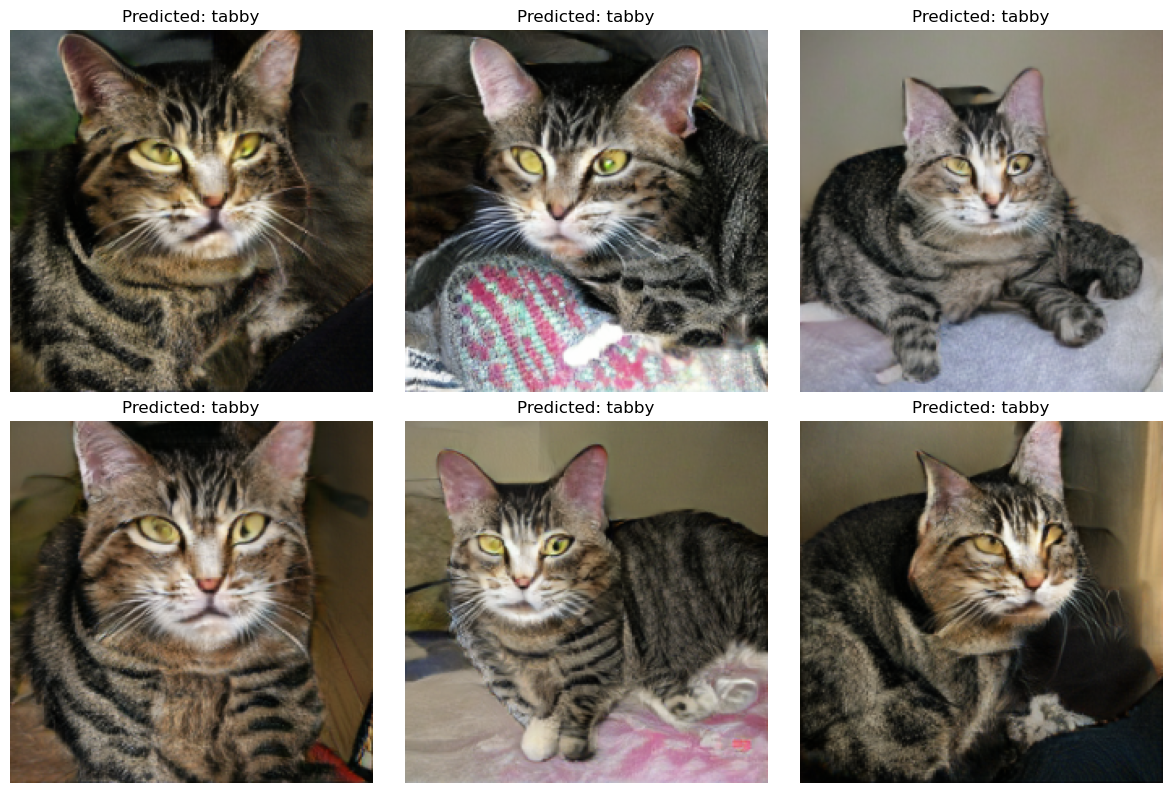

In [2]:
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json
import requests
from torchvision import models

#Set batch size (number of images to generate)
batch_size = 30

# Use the same class for all images, e.g., "tabby cat"
class_names = ['tabby cat'] * batch_size
class_vector = one_hot_from_names(class_names, batch_size=batch_size)
class_vector = torch.tensor(class_vector).to(device)

# Generate a batch of truncated noise vectors
noise_vector = truncated_noise_sample(truncation=0.4, batch_size=batch_size)
noise_vector = torch.tensor(noise_vector).to(device)

# Generate images (BigGAN typically outputs tensors in a range that may not be [0,1])
with torch.no_grad():
    output = biggan(noise_vector, class_vector, 0.4)

# Post-process the generated images:
# For classification we assume BigGAN outputs in [-1, 1]; we scale them to [0, 1]
generated_images = (output + 1) / 2.0  # shape: [batch_size, 3, H, W]

# Optionally, save a grid of the generated images
vutils.save_image(generated_images, "generated_images_grid.png", nrow=6, normalize=True)
print("Generated images saved as generated_images_grid.png")

# ------------------------------------------------------------------------------
# 2. Preprocess the Generated Images for ResNet Classification
# ------------------------------------------------------------------------------
# ResNet expects images of size 224x224 and normalized using ImageNet stats.
# We can use interpolation to resize and then apply normalization.

# Resize images to 224x224
resized_images = F.interpolate(generated_images, size=(224, 224), mode='bilinear', align_corners=False)

# Define ImageNet normalization mean and std
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

# Normalize the images
normalized_images = (resized_images - imagenet_mean) / imagenet_std

# ------------------------------------------------------------------------------
# 3. Load Pretrained ResNet-152 and Classify the Images
# ------------------------------------------------------------------------------
print("Loading pretrained ResNet-152 for classification...")
resnet = models.resnet152(pretrained=True)
resnet.eval()
resnet.to(device)

with torch.no_grad():
    outputs = resnet(normalized_images)
    # Get the predicted class index for each image
    _, predicted_indices = torch.max(outputs, 1)

# ------------------------------------------------------------------------------
# 4. Decode Predictions using ImageNet Class Index Mapping
# ------------------------------------------------------------------------------
# Download the ImageNet class index file if not present.
IMAGENET_CLASS_INDEX = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
response = requests.get(IMAGENET_CLASS_INDEX)
class_idx = json.loads(response.content)

# Create a mapping from index to human-readable label
idx_to_label = {int(key): value[1] for key, value in class_idx.items()}

# Print predicted labels for each generated image
print("\nPredicted ImageNet Classes for Generated Images:")
for i, idx in enumerate(predicted_indices.cpu().numpy()):
    print(f"Image {i+1}: {idx_to_label.get(idx, 'Unknown')}")

# ------------------------------------------------------------------------------
# 5. (Optional) Visualize a few Generated Images with their Predictions
# ------------------------------------------------------------------------------
# Move images to CPU and denormalize for display
def denormalize(img_tensor):
    """Convert a normalized tensor to [0, 1] range for display."""
    img = img_tensor.clone()
    for c, (m, s) in enumerate(zip(imagenet_mean.view(-1), imagenet_std.view(-1))):
        img[c] = img[c] * s + m
    return img.clamp(0, 1)

# Select first 6 images for visualization
vis_images = resized_images[:6].cpu()
vis_preds = predicted_indices[:6].cpu().numpy()

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i in range(6):
    # Denormalize (since we classified using normalized images, we use the resized but unnormalized images for display)
    img = vis_images[i]
    # If needed, ensure img is in [0,1] (BigGAN scaling already did that)
    img = img.clamp(0, 1)
    # Permute for matplotlib display: [C, H, W] -> [H, W, C]
    img = img.permute(1, 2, 0).numpy()
    label = idx_to_label.get(int(vis_preds[i]), "Unknown")
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In this project, a pretrained ResNet50 serves as the **teacher** network, while a smaller ResNet18 is adapted to be the **student** network. The teacher is wrapped so that its forward pass returns both the final logits, $T_{\text{logits}}$, and a pooled feature vector from its second residual block, $T_{\text{feat}}$. These features represent high-level representations learned by the teacher. The teacher is fixed during training to provide consistent guidance.

The student network is modified by replacing its final fully connected layer to output $n$ logits (matching the teacher’s output size) and by attaching an additional branch to its second residual block. This extra branch, composed of two linear layers with a ReLU activation, processes the pooled features from the student’s layer2 to produce an auxiliary output, $S_{\text{aux}}$, of dimension $d_{\text{teacher}}$. During training, the student is optimized to minimize the mean squared error between its logits $S_{\text{logits}}$ and the teacher’s logits, as well as between its auxiliary output and $T_{\text{feat}}$, i.e., $$L_{\text{total}} = \|S_{\text{logits}} - T_{\text{logits}}\|^2 + \|S_{\text{aux}} - T_{\text{feat}}\|^2.$$ This encourages the student to mimic not only the final predictions but also the internal representations of the teacher.

Overall, the design leverages knowledge distillation by transferring both output-level and feature-level knowledge from a large model to a compact one. This dual-objective strategy aims to yield a student network that is more efficient at inference while retaining much of the accuracy and representational power of the teacher.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

# Device configuration
device = torch.device("mps" if torch.mps.is_available() else "cpu")


###############################################################################
# 1. Define the Teacher Network Wrapper
###############################################################################
# Use a pretrained ResNet50 as teacher.
teacher = models.resnet50(pretrained=True).to(device)
teacher.eval()  # Teacher is fixed.

# Wrap the teacher so that its forward() returns:
#   - logits (final output of dimension n, e.g., 1000)
#   - a pooled feature vector from its 2nd residual block (layer2), of dimension d.
class TeacherWrapper(nn.Module):
    def __init__(self, teacher_net):
        super(TeacherWrapper, self).__init__()
        self.teacher = teacher_net

    def forward(self, x):
        # Standard ResNet forward up to layer2:
        x = self.teacher.conv1(x)
        x = self.teacher.bn1(x)
        x = self.teacher.relu(x)
        x = self.teacher.maxpool(x)
        x = self.teacher.layer1(x)
        feat2 = self.teacher.layer2(x)  # 2nd residual block features

        # Pool the layer2 features to get a vector.
        # (teacher.avgpool is AdaptiveAvgPool2d((1,1)) in ResNet.)
        pooled_feat2 = self.teacher.avgpool(feat2)
        pooled_feat2 = torch.flatten(pooled_feat2, 1)  # shape: [batch, d]

        # Continue with the rest of the network:
        x = self.teacher.layer3(feat2)  # Note: in standard ResNet, input to layer3 is output of layer2.
        x = self.teacher.layer4(x)
        x = self.teacher.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.teacher.fc(x)
        return logits, pooled_feat2

teacher_wrapper = TeacherWrapper(teacher)


###############################################################################
# 2. Define the Student Network with Extra Branch
###############################################################################
# We build a student based on ResNet18.
student = models.resnet18(pretrained=False)
# Set student’s final fc layer to output n dimensions (matching teacher logits).
n = teacher.fc.out_features  # typically 1000.
student.fc = nn.Linear(student.fc.in_features, n)

# The student’s second residual block (layer2) in ResNet18 outputs feature maps
# with 128 channels. We will pool these to a 128-dim vector.
student_d = 128

# We want the extra branch to output a vector of dimension d_teacher.
# For our teacher (ResNet50), when we pool layer2 features we get a vector of size:
#   d_teacher = teacher.layer2 output channels (which is 512 for ResNet50).
d_teacher = 512

# Define the extra branch: two Linear layers with a ReLU in between.
class ExtraBranch(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ExtraBranch, self).__init__()
        self.branch = nn.Sequential(
            nn.Linear(in_dim, in_dim),  # hidden dimension chosen as in_dim
            nn.ReLU(),
            nn.Linear(in_dim, out_dim)
        )
        # Initialize weights i.i.d. normal for the linear layers.
        for m in self.branch:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        return self.branch(x)

extra_branch = ExtraBranch(in_dim=student_d, out_dim=d_teacher).to(device)

# Wrap the student network so that it uses the extra branch.
class StudentWrapper(nn.Module):
    def __init__(self, student_net, extra_branch):
        super(StudentWrapper, self).__init__()
        self.student = student_net
        self.extra_branch = extra_branch

    def forward(self, x):
        # Forward pass through initial layers:
        x = self.student.conv1(x)
        x = self.student.bn1(x)
        x = self.student.relu(x)
        x = self.student.maxpool(x)
        x = self.student.layer1(x)
        feat2 = self.student.layer2(x)  # student's 2nd residual block
        
        # Pool the features from layer2 to obtain a vector.
        pooled_feat2 = F.adaptive_avg_pool2d(feat2, (1, 1)).view(feat2.size(0), -1)  # shape: [batch, 128]
        # Pass the pooled features through the extra branch.
        extra_out = self.extra_branch(pooled_feat2)  # shape: [batch, d_teacher]
        
        # Continue forward through the remaining layers of student.
        x = self.student.layer3(feat2)  # note: in ResNet, layer3 takes output of layer2.
        x = self.student.layer4(x)
        x = self.student.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.student.fc(x)  # shape: [batch, n]
        
        # Concatenate the student logits and the extra branch output.
        # Final student output has dimension n + d_teacher.
        student_output = torch.cat([logits, extra_out], dim=1)
        return student_output, logits, extra_out

student_wrapper = StudentWrapper(student, extra_branch).to(device)

# Initialize student network weights i.i.d. normal.
def init_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.01)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

student_wrapper.apply(init_weights)




/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


StudentWrapper(
  (student): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

We next check that all the dimensions are correct!

In [4]:
# Define a dummy input (e.g., batch of 8 images, size 3x224x224)
batch_size = 8
dummy_input = torch.randn(batch_size, 3, 224, 224).to(device)

# Forward pass through teacher
teacher_logits, teacher_feat2 = teacher_wrapper(dummy_input)
print("Teacher logits shape:", teacher_logits.shape)       # Expected: [8, n]
print("Teacher pooled feature shape:", teacher_feat2.shape)  # Expected: [8, d_teacher]

# Forward pass through student
student_output, student_logits, student_extra = student_wrapper(dummy_input)
print("Student concatenated output shape:", student_output.shape)  # Expected: [8, n + d_teacher]
print("Student main logits shape:", student_logits.shape)          # Expected: [8, n]
print("Student extra branch output shape:", student_extra.shape)     # Expected: [8, d_teacher]

# Retrieve expected dimensions from our model definitions.
n = teacher.fc.out_features  # typically 1000
d_teacher = 512              # for ResNet50, the teacher's layer2 pooled feature dimension

# Verify teacher outputs
assert teacher_logits.shape == (batch_size, n), f"Teacher logits shape mismatch. Got {teacher_logits.shape}, expected {(batch_size, n)}"
assert teacher_feat2.shape == (batch_size, d_teacher), f"Teacher pooled features shape mismatch. Got {teacher_feat2.shape}, expected {(batch_size, d_teacher)}"

# Verify student outputs
assert student_logits.shape == (batch_size, n), f"Student logits shape mismatch. Got {student_logits.shape}, expected {(batch_size, n)}"
assert student_extra.shape == (batch_size, d_teacher), f"Student extra branch output shape mismatch. Got {student_extra.shape}, expected {(batch_size, d_teacher)}"
assert student_output.shape == (batch_size, n + d_teacher), f"Student concatenated output shape mismatch. Got {student_output.shape}, expected {(batch_size, n + d_teacher)}"

print("All dimensions are correct!")

Teacher logits shape: torch.Size([8, 1000])
Teacher pooled feature shape: torch.Size([8, 512])
Student concatenated output shape: torch.Size([8, 1512])
Student main logits shape: torch.Size([8, 1000])
Student extra branch output shape: torch.Size([8, 512])
All dimensions are correct!


Next we generate validation data!

In [5]:
import os
import glob
import csv
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

# Assume teacher_wrapper and student_wrapper are defined as in the previous code.
# (They implement the knowledge distillation model where the student output is composed
# of main logits (n dims) and an extra branch (d_teacher dims) and are trained with an MSE loss.)
#
# For completeness, we assume that:
#   - teacher_wrapper is a wrapper around a pretrained ResNet50.
#   - student_wrapper is a wrapper around a ResNet18 with an extra branch.
#
# (See the previous training code for their definitions.)

# For this code snippet, we assume teacher_wrapper and student_wrapper are already defined.
# If running this code stand-alone, please define them as in the earlier example.
# ------------------------------------------------------------------------------
# Additional Setup
# ------------------------------------------------------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cpu")

# Load BigGAN (we use the Hugging Face pretrained BigGAN)
print("Loading BigGAN-deep-256 from Hugging Face...")
biggan = BigGAN.from_pretrained('biggan-deep-256')
biggan.eval()
biggan.to(device)

# Define the number of ImageNet classes used by BigGAN.
NUM_CLASSES = 1000

# Directory names for saving data and models.
VAL_DIR = os.path.join(os.getcwd(), "val_data")
if not os.path.exists(VAL_DIR):
    os.makedirs(VAL_DIR)

# CSV file to store per-epoch losses.
CSV_FILENAME = os.path.join(os.getcwd(), "losses.csv")
csv_header = ['epoch', 'training_loss', 'validation_loss', 'val_top5_accuracy']

# If CSV file does not exist, write header.
if not os.path.exists(CSV_FILENAME):
    with open(CSV_FILENAME, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(csv_header)

# ------------------------------------------------------------------------------
# Helper function: generate a dataset using BigGAN.
# For each image, we randomly select an integer class in [0, NUM_CLASSES-1],
# create a one-hot vector for that class, generate a noise vector, and then produce an image.
# Optionally, if save_folder is provided, the image is saved.
def generate_biggan_dataset(num_images, save_folder=None):
    images_list = []
    labels_list = []
    for i in range(num_images):
        # Randomly choose a class index.
        random_class = random.randint(0, NUM_CLASSES - 1)
        # Create a one-hot vector for that class.
        class_vector = torch.zeros(1, NUM_CLASSES, device=device)
        class_vector[0, random_class] = 1.0

        # Generate a noise vector (BigGAN expects a noise vector of size 128).
        noise_vector = truncated_noise_sample(truncation=0.4, batch_size=1)
        noise_vector = torch.tensor(noise_vector, device=device)

        # Generate image with BigGAN.
        with torch.no_grad():
            output = biggan(noise_vector, class_vector, 0.4)
        # The output is of shape [1, 3, H, W]. (Typically H and W are 256.)
        image = output.squeeze(0)  # [3, H, W]

        # Optionally save the image.
        if save_folder is not None:
            filename = os.path.join(save_folder, f"img_{i}.png")
            # Use torchvision.utils.save_image to normalize to [0,1] for saving.
            vutils.save_image(image, filename, normalize=True)

        images_list.append(image.cpu())
        labels_list.append(random_class)

    # Stack images into a single tensor.
    images_tensor = torch.stack(images_list)  # [num_images, 3, H, W]
    labels_tensor = torch.tensor(labels_list)
    return images_tensor, labels_tensor

# ------------------------------------------------------------------------------
# 1. Generate and Save the Validation Dataset (1000 images)
# ------------------------------------------------------------------------------
print("Generating validation dataset with 1000 images...")
# Check if VAL_DIR exists and contains exactly 1000 .jpg images
if os.path.exists(VAL_DIR):
    jpg_files = glob.glob(os.path.join(VAL_DIR, "*.png"))
    if len(jpg_files) == 1000:
        print(f"Validation dataset already exists with {len(jpg_files)} images in {VAL_DIR}. Skipping generation.")
    else:
        print(f"Validation dataset incomplete ({len(jpg_files)}/1000 images). Regenerating dataset...")
        val_images, val_labels = generate_biggan_dataset(1000, save_folder=VAL_DIR)
        val_labels_csv = os.path.join(VAL_DIR, "val_labels.csv")
        with open(val_labels_csv, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['index', 'label'])
            for idx, label in enumerate(val_labels.tolist()):
                writer.writerow([idx, label])
        print(f"Validation labels saved to {val_labels_csv}.")
        print(f"Validation dataset saved in {VAL_DIR}.")
else:
    print("Validation dataset directory does not exist. Creating and generating dataset...")
    os.makedirs(VAL_DIR, exist_ok=True)
    val_images, val_labels = generate_biggan_dataset(1000, save_folder=VAL_DIR)
    print(f"Validation dataset saved in {VAL_DIR}.")



Loading BigGAN-deep-256 from Hugging Face...
Generating validation dataset with 1000 images...
Validation dataset already exists with 1000 images in /Users/ryanaschoff/Documents/val_data. Skipping generation.


This code sets up the device (using MPS if available) and loads necessary modules for training and validating a student network through knowledge distillation. In particular, it defines image transformations (resizing, converting to tensors, and normalizing with ImageNet statistics) and reads validation labels from a CSV file stored in the validation folder. For each line in the CSV, it constructs an expected filename (e.g., `img_{index}.png`), checks if the image exists, and then accumulates the file paths and labels. Once the images are loaded with the PIL library and transformed, they are stacked into a tensor of shape `[1000, 3, 224, 224]`, and the labels are converted into a tensor. Finally, a `TensorDataset` is created from these tensors, and a `DataLoader` is built for validation, ensuring that the validation data is correctly and consistently processed.

The validation process here is performed by iterating over the CSV file to verify that each image exists in the designated folder, thus ensuring data consistency before training begins. The code applies the same transformations to the validation images as used during training, which is crucial for model performance. After reading and transforming the images, the data is batched (with a batch size of 32) without shuffling, which is typical during validation to preserve order and allow consistent evaluation across epochs. This validation DataLoader is then used in the training loop to compute losses and top-5 accuracy on a held-out set, which is logged and plotted every 10 epochs.

The remainder of the code wraps the BigGAN, teacher, and student models in DataParallel (using two devices), generates synthetic training data on the fly via BigGAN, and trains the student network by comparing both its final logits and its auxiliary outputs (from the extra branch) to the teacher’s outputs. The training loop computes a mean squared error loss between the student and teacher outputs, updates the student’s weights, and logs performance metrics, ensuring that both training and validation losses, as well as accuracy, are tracked over epochs.


Using device: mps
Validation DataLoader created successfully!
Starting to train!
Epoch 1/50: Train Loss = 3.6736, Val Loss = 5.8365, Top5 Acc = 0.60%
Epoch 2/50: Train Loss = 3.2158, Val Loss = 4.6858, Top5 Acc = 2.90%
Epoch 3/50: Train Loss = 2.9785, Val Loss = 4.6665, Top5 Acc = 4.40%
Epoch 4/50: Train Loss = 2.8140, Val Loss = 4.7250, Top5 Acc = 5.90%
Epoch 5/50: Train Loss = 2.6441, Val Loss = 4.4919, Top5 Acc = 7.40%
Epoch 6/50: Train Loss = 2.5701, Val Loss = 4.5275, Top5 Acc = 5.80%
Epoch 7/50: Train Loss = 2.4572, Val Loss = 4.9039, Top5 Acc = 5.50%
Epoch 8/50: Train Loss = 2.3897, Val Loss = 4.4816, Top5 Acc = 7.20%
Epoch 9/50: Train Loss = 2.2994, Val Loss = 4.2476, Top5 Acc = 9.20%
Epoch 10/50: Train Loss = 2.2268, Val Loss = 4.3820, Top5 Acc = 8.70%


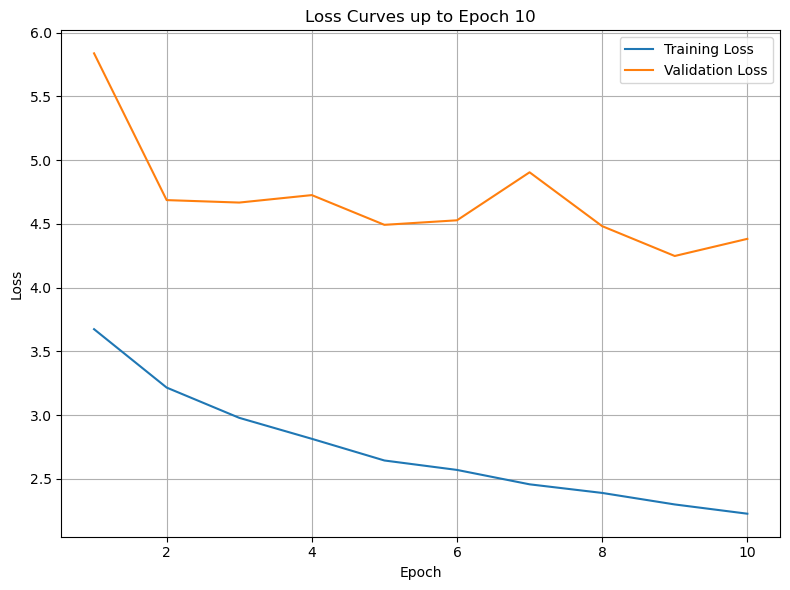

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_10.png
Epoch 11/50: Train Loss = 2.2034, Val Loss = 4.1406, Top5 Acc = 14.90%
Epoch 12/50: Train Loss = 2.0913, Val Loss = 3.7662, Top5 Acc = 19.20%
Epoch 13/50: Train Loss = 2.0607, Val Loss = 4.1196, Top5 Acc = 15.30%
Epoch 14/50: Train Loss = 2.0066, Val Loss = 4.0409, Top5 Acc = 18.90%
Epoch 15/50: Train Loss = 1.9420, Val Loss = 3.8556, Top5 Acc = 26.20%
Epoch 16/50: Train Loss = 1.8860, Val Loss = 4.2202, Top5 Acc = 17.20%
Epoch 17/50: Train Loss = 1.8535, Val Loss = 3.9701, Top5 Acc = 21.50%
Epoch 18/50: Train Loss = 1.7901, Val Loss = 3.9455, Top5 Acc = 22.70%
Epoch 19/50: Train Loss = 1.7523, Val Loss = 3.7146, Top5 Acc = 30.40%
Epoch 20/50: Train Loss = 1.7047, Val Loss = 3.9705, Top5 Acc = 26.60%


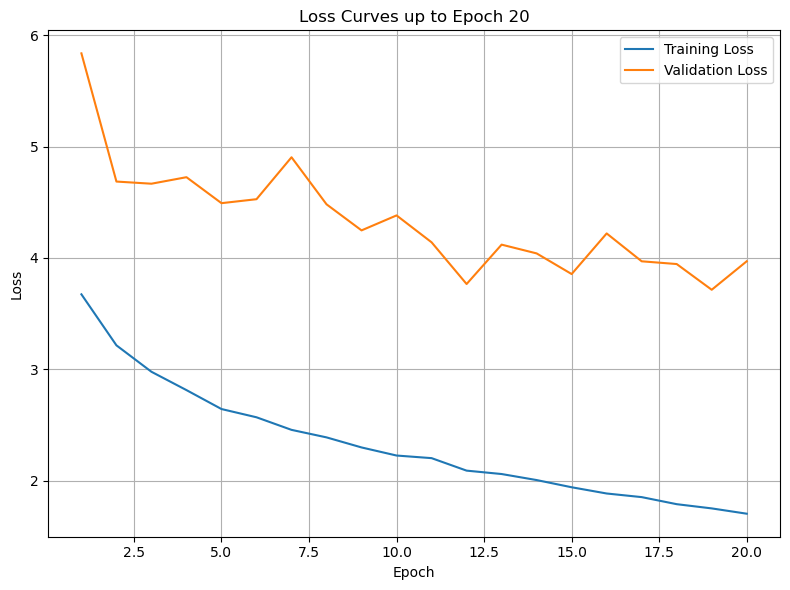

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_20.png
Epoch 21/50: Train Loss = 1.6546, Val Loss = 3.9457, Top5 Acc = 26.10%
Epoch 22/50: Train Loss = 1.6349, Val Loss = 3.8059, Top5 Acc = 29.10%
Epoch 23/50: Train Loss = 1.5972, Val Loss = 4.0439, Top5 Acc = 27.30%
Epoch 24/50: Train Loss = 1.5550, Val Loss = 3.8272, Top5 Acc = 27.90%
Epoch 25/50: Train Loss = 1.5269, Val Loss = 3.7701, Top5 Acc = 31.00%
Epoch 26/50: Train Loss = 1.5008, Val Loss = 4.0747, Top5 Acc = 27.20%
Epoch 27/50: Train Loss = 1.4672, Val Loss = 3.6804, Top5 Acc = 37.70%
Epoch 28/50: Train Loss = 1.4472, Val Loss = 3.8864, Top5 Acc = 37.10%
Epoch 29/50: Train Loss = 1.4266, Val Loss = 4.0144, Top5 Acc = 34.00%
Epoch 30/50: Train Loss = 1.3797, Val Loss = 4.0937, Top5 Acc = 32.30%


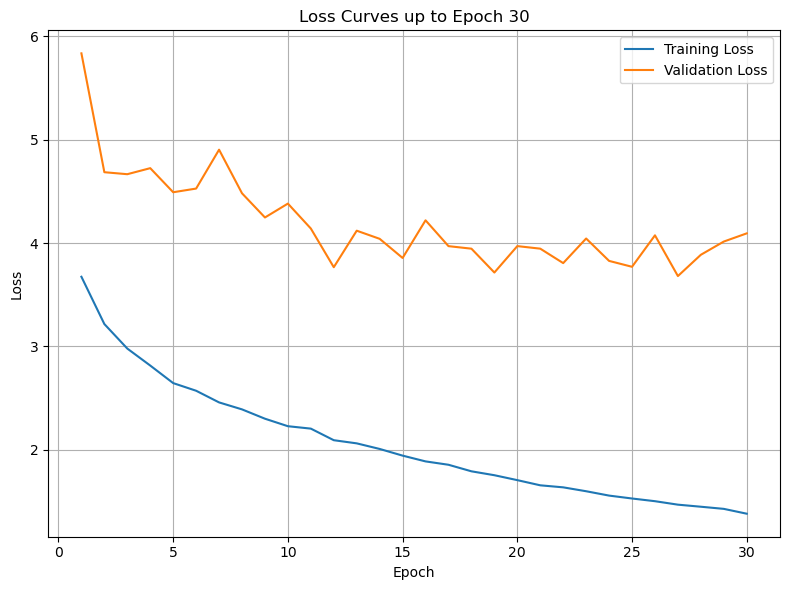

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_30.png
Epoch 31/50: Train Loss = 1.3618, Val Loss = 3.6451, Top5 Acc = 40.70%
Epoch 32/50: Train Loss = 1.3387, Val Loss = 4.1919, Top5 Acc = 28.60%
Epoch 33/50: Train Loss = 1.3087, Val Loss = 3.7079, Top5 Acc = 42.10%
Epoch 34/50: Train Loss = 1.3003, Val Loss = 3.9132, Top5 Acc = 38.50%
Epoch 35/50: Train Loss = 1.2609, Val Loss = 3.5330, Top5 Acc = 48.60%
Epoch 36/50: Train Loss = 1.2481, Val Loss = 4.2415, Top5 Acc = 33.40%
Epoch 37/50: Train Loss = 1.2332, Val Loss = 3.9711, Top5 Acc = 38.10%
Epoch 38/50: Train Loss = 1.2056, Val Loss = 3.7787, Top5 Acc = 41.80%
Epoch 39/50: Train Loss = 1.1886, Val Loss = 3.5701, Top5 Acc = 51.50%
Epoch 40/50: Train Loss = 1.1788, Val Loss = 3.6178, Top5 Acc = 47.20%


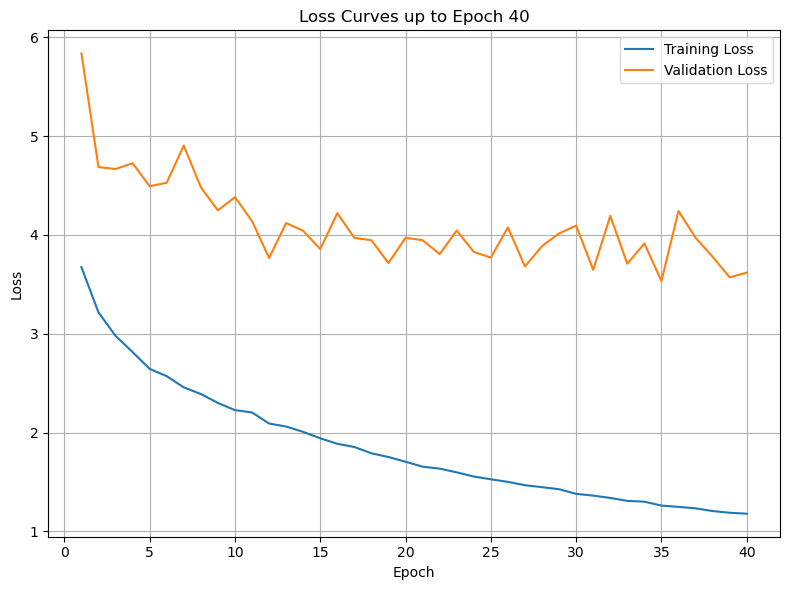

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_40.png
Epoch 41/50: Train Loss = 1.1596, Val Loss = 3.6883, Top5 Acc = 45.00%
Epoch 42/50: Train Loss = 1.1346, Val Loss = 3.5058, Top5 Acc = 48.20%
Epoch 43/50: Train Loss = 1.1159, Val Loss = 3.3651, Top5 Acc = 56.60%
Epoch 44/50: Train Loss = 1.1094, Val Loss = 3.4238, Top5 Acc = 53.70%
Epoch 45/50: Train Loss = 1.1029, Val Loss = 3.5749, Top5 Acc = 50.50%
Epoch 46/50: Train Loss = 1.0691, Val Loss = 3.6064, Top5 Acc = 51.80%
Epoch 47/50: Train Loss = 1.0613, Val Loss = 3.4937, Top5 Acc = 50.80%
Epoch 48/50: Train Loss = 1.0532, Val Loss = 3.6919, Top5 Acc = 48.80%
Epoch 49/50: Train Loss = 1.0422, Val Loss = 3.3352, Top5 Acc = 58.60%
Epoch 50/50: Train Loss = 1.0306, Val Loss = 3.6486, Top5 Acc = 47.70%


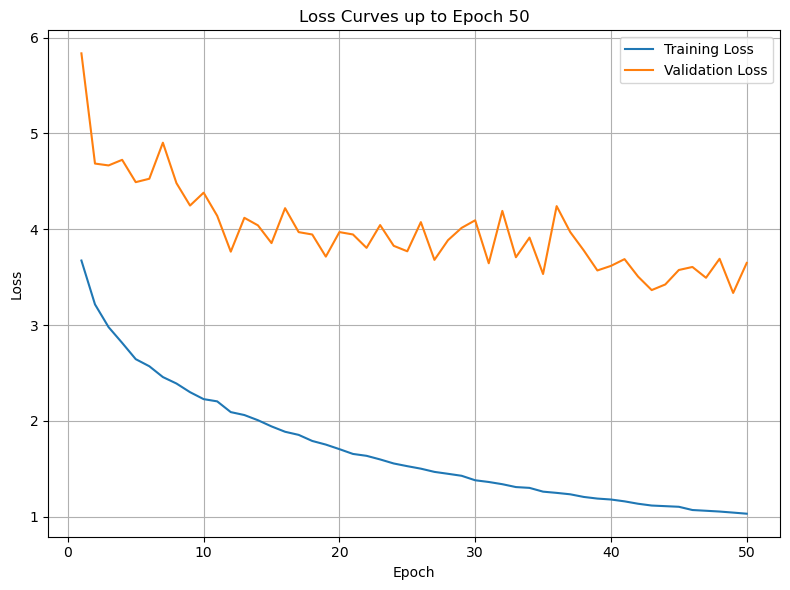

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_50.png


In [6]:
from torch.utils.data import TensorDataset, DataLoader

import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image


# Make sure the device is set to mps if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)
torch.mps.empty_cache()
# ------------------------------------------------------------------------------
# Save Validation Labels to CSV in the VAL_DIR folder
# ------------------------------------------------------------------------------


# Define image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure images are resized to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 1: Read the labels from CSV
val_labels = []
image_filenames = []

VAL_LABELS_CSV = os.path.join(VAL_DIR, "val_labels.csv")
with open(VAL_LABELS_CSV, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        index, label = row  # Read index and label
        image_filename = os.path.join(VAL_DIR, f"img_{index}.png")  # Ensure correct filename
        if os.path.exists(image_filename):  # Ensure the image exists
            image_filenames.append(image_filename)
            val_labels.append(int(label))

# Step 2: Load images and convert them to tensors
val_images = []
for img_path in image_filenames:
    image = Image.open(img_path).convert("RGB")  # Open image in RGB mode
    image = transform(image)  # Apply transformations
    val_images.append(image)

# Convert list of images and labels to PyTorch tensors
val_images = torch.stack(val_images)  # Shape: [1000, 3, 224, 224]
val_labels = torch.tensor(val_labels, dtype=torch.long)  # Shape: [1000]

# Step 3: Create a TensorDataset and DataLoader
val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Validation DataLoader created successfully!")
# ------------------------------------------------------------------------------
# 2. Training Phase
# ------------------------------------------------------------------------------
print('Starting to train!')

device_ids = list(range(2))

# Ensure that any models (teacher, student, etc.) are moved to the selected device.
# For example, if your model is called model and your student wrapper is student_wrapper:
student_wrapper.to(device)

# Hyperparameters for training.
num_epochs = 50
train_set_size = 10000  # number of training images per epoch
batch_size_train = 32

# Loss function: Mean Squared Error (as used for distillation)
criterion = nn.MSELoss()
optimizer = optim.SGD(student_wrapper.parameters(), lr=0.01, momentum=0.9)

# Lists to record per-epoch losses and top5 accuracy for plotting and CSV logging.
train_loss_history = []
val_loss_history = []
top5_accuracy_history = []

# We'll record the losses and top-5 accuracy each epoch.
for epoch in range(1, num_epochs + 1):
    student_wrapper.train()
    # Generate training data for this epoch (on the fly)
    train_images, train_labels = generate_biggan_dataset(train_set_size, save_folder=None)
    train_dataset = TensorDataset(train_images, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    
    epoch_train_loss = 0.0
    num_train_batches = 0
    
    for images, labels in train_loader:
        images = images.to(device)  # images generated by BigGAN
        # For consistency with our teacher/student wrappers (which expect images in the range used by ImageNet models),
        # we assume BigGAN output is scaled appropriately. Adjust scaling if needed.
        
        # Get teacher outputs (logits and pooled features).
        with torch.no_grad():
            teacher_logits, teacher_feat2 = teacher_wrapper(images)
        
        # Get student outputs: student_wrapper returns (student_output, student_logits, student_extra)
        student_out, student_logits, student_extra = student_wrapper(images)
        
        # Compute the loss as the sum of:
        # (a) MSE loss between teacher logits and student logits, and
        # (b) MSE loss between teacher's pooled features and student's extra branch output.
        loss_logits = criterion(student_logits, teacher_logits)
        loss_feat = criterion(student_extra, teacher_feat2)
        loss = loss_logits + loss_feat
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_train_batches += 1

    avg_train_loss = epoch_train_loss / num_train_batches
    train_loss_history.append(avg_train_loss)

    # -----------------------------
    # Validation Phase: Evaluate student model performance.
    # -----------------------------
    student_wrapper.eval()
    val_loss_total = 0.0
    num_val_batches = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            teacher_logits, teacher_feat2 = teacher_wrapper(images)
            student_out, student_logits, student_extra = student_wrapper(images)
            loss_logits = criterion(student_logits, teacher_logits)
            loss_feat = criterion(student_extra, teacher_feat2)
            loss_val = loss_logits + loss_feat

            val_loss_total += loss_val.item()
            num_val_batches += 1

            # Compute the top 5 predicted class indices.
            top5_val, pred_top5 = torch.topk(student_logits, k=5, dim=1)
            # Check if the true label is among the top 5 predictions.
            for i in range(pred_top5.size(0)):
                if labels[i] in pred_top5[i]:
                    correct_top5 += 1
            total += labels.size(0)

    avg_val_loss = val_loss_total / num_val_batches
    val_loss_history.append(avg_val_loss)
    top5_accuracy = 100.0 * correct_top5 / total
    top5_accuracy_history.append(top5_accuracy)

    # Save the student model for this epoch.
    model_filename = os.path.join(os.getcwd(), f"student_epoch_{epoch}.pth")
    torch.save(student_wrapper.state_dict(), model_filename)

    # Print losses and validation top5 accuracy.
    print(f"Epoch {epoch}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Top5 Acc = {top5_accuracy:.2f}%")
    
    # Append losses and top5 accuracy to CSV file.
    with open(CSV_FILENAME, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([epoch, avg_train_loss, avg_val_loss, top5_accuracy])
    
    # Every 10 epochs, plot the training and validation losses.
    if epoch % 10 == 0:
        plt.figure(figsize=(8, 6))
        epochs_range = range(1, epoch + 1)
        plt.plot(epochs_range, train_loss_history, label='Training Loss')
        plt.plot(epochs_range, val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss Curves up to Epoch {epoch}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        # Optionally, you can save the plot:
        plot_filename = os.path.join(os.getcwd(), f"loss_plot_epoch_{epoch}.png")
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved loss plot to {plot_filename}")

Now we test whether it worked!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9991923..0.8965038].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9963627..0.9138408].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9931744..0.98807126].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9898361..0.94946295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9996443..0.9999192].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9961072..0.9959287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9874

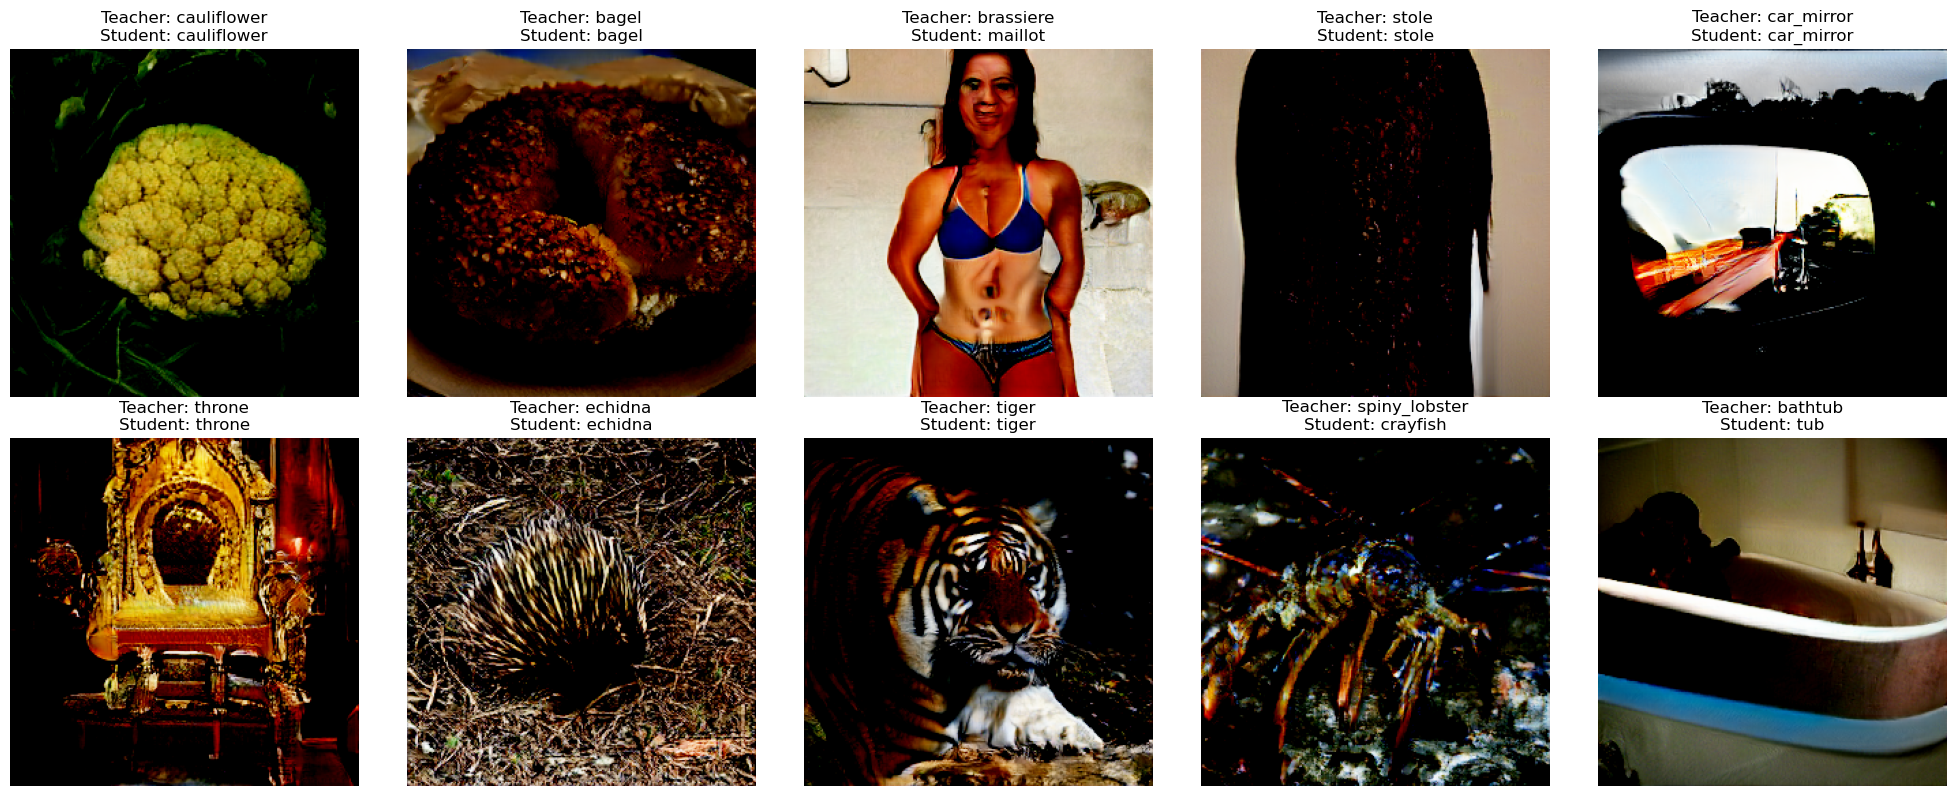

In [8]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# --- Generate 10 images using BigGAN ---
num_display = 10
# Here, we generate 10 images on the fly. The function should return:
#   - images_tensor: a tensor of shape [num_display, 3, H, W]
#   - labels_tensor: a tensor of class indices used to condition generation (if applicable)
images_tensor, _ = generate_biggan_dataset(num_display, save_folder=None)

# Make sure the images are on the correct device (they should already be on CPU since we moved them in generate_biggan_dataset)
images_tensor = images_tensor.to(device)

# --- Get predictions from teacher and student ---
# Teacher forward: teacher_wrapper should return (teacher_logits, teacher_feat2)
with torch.no_grad():
    teacher_logits, _ = teacher_wrapper(images_tensor)
    # Get teacher predictions: top-1 index per image.
    teacher_preds = torch.argmax(teacher_logits, dim=1)

# Student forward: student_wrapper returns (student_output, student_logits, student_extra)
with torch.no_grad():
    _, student_logits, _ = student_wrapper(images_tensor)
    # Get student predictions: top-1 index per image.
    student_preds = torch.argmax(student_logits, dim=1)

# --- Optionally, convert indices to human-readable labels ---
# If you have a dictionary mapping (e.g., idx_to_label), you can use it.
# If not, the code will just display the indices.
def get_label(idx):
    try:
        return idx_to_label[idx]
    except NameError:
        # If idx_to_label is not defined, just return the index.
        return str(idx)
    except KeyError:
        return str(idx)

# --- Plot images with teacher and student predictions ---
# We'll display the images in a grid. For each image, display the teacher and student prediction in the title.
images_cpu = images_tensor.cpu()  # ensure images are on CPU for plotting
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # grid with 2 rows and 5 columns (total 10 images)
axes = axes.flatten()

for i in range(num_display):
    # Denormalize the image (assuming images were normalized in generation/scaling)
    # If your BigGAN output is in range [0,1] or already normalized for display, adjust accordingly.
    # Here we assume the images are in [0, 1] after generation.
    img = images_cpu[i]
    # If needed, you can apply additional normalization. Here, we simply move the tensor to numpy:
    img_np = img.permute(1, 2, 0).numpy()
    
    # Get predictions as either labels or indices.
    teacher_label = get_label(teacher_preds[i].item())
    student_label = get_label(student_preds[i].item())
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"Teacher: {teacher_label}\nStudent: {student_label}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

It looks like the training did not yet converge in loss, so we run it for more time.

Epoch 1/50: Train Loss = 0.9143, Val Loss = 3.2802, Top5 Acc = 61.20%
Epoch 2/50: Train Loss = 0.9125, Val Loss = 3.2581, Top5 Acc = 61.10%
Epoch 3/50: Train Loss = 0.9094, Val Loss = 3.2154, Top5 Acc = 63.60%
Epoch 4/50: Train Loss = 0.8902, Val Loss = 3.1545, Top5 Acc = 65.70%
Epoch 5/50: Train Loss = 0.8958, Val Loss = 3.4566, Top5 Acc = 56.30%
Epoch 6/50: Train Loss = 0.8738, Val Loss = 3.4368, Top5 Acc = 57.50%
Epoch 7/50: Train Loss = 0.8737, Val Loss = 3.1232, Top5 Acc = 65.50%
Epoch 8/50: Train Loss = 0.8718, Val Loss = 3.3336, Top5 Acc = 60.10%
Epoch 9/50: Train Loss = 0.8636, Val Loss = 3.0991, Top5 Acc = 68.60%
Epoch 10/50: Train Loss = 0.8573, Val Loss = 3.1340, Top5 Acc = 65.50%


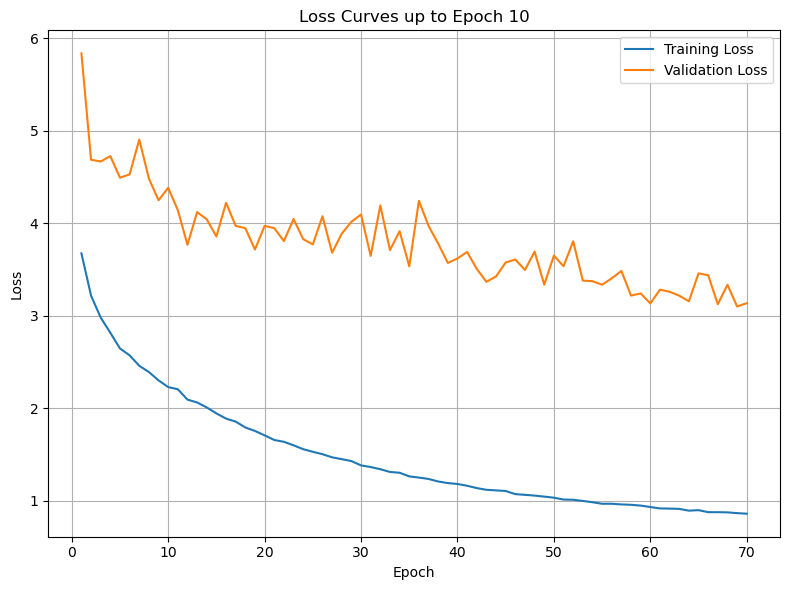

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_10.png
Epoch 11/50: Train Loss = 0.8527, Val Loss = 3.2605, Top5 Acc = 63.70%
Epoch 12/50: Train Loss = 0.8447, Val Loss = 3.0015, Top5 Acc = 69.80%
Epoch 13/50: Train Loss = 0.8379, Val Loss = 3.2905, Top5 Acc = 61.10%
Epoch 14/50: Train Loss = 0.8312, Val Loss = 3.1027, Top5 Acc = 67.90%
Epoch 15/50: Train Loss = 0.8191, Val Loss = 3.2041, Top5 Acc = 65.10%
Epoch 16/50: Train Loss = 0.8235, Val Loss = 2.9440, Top5 Acc = 72.30%
Epoch 17/50: Train Loss = 0.8131, Val Loss = 3.2354, Top5 Acc = 64.20%
Epoch 18/50: Train Loss = 0.8195, Val Loss = 3.1428, Top5 Acc = 67.20%
Epoch 19/50: Train Loss = 0.8069, Val Loss = 3.2137, Top5 Acc = 63.80%
Epoch 20/50: Train Loss = 0.8055, Val Loss = 3.0293, Top5 Acc = 71.20%


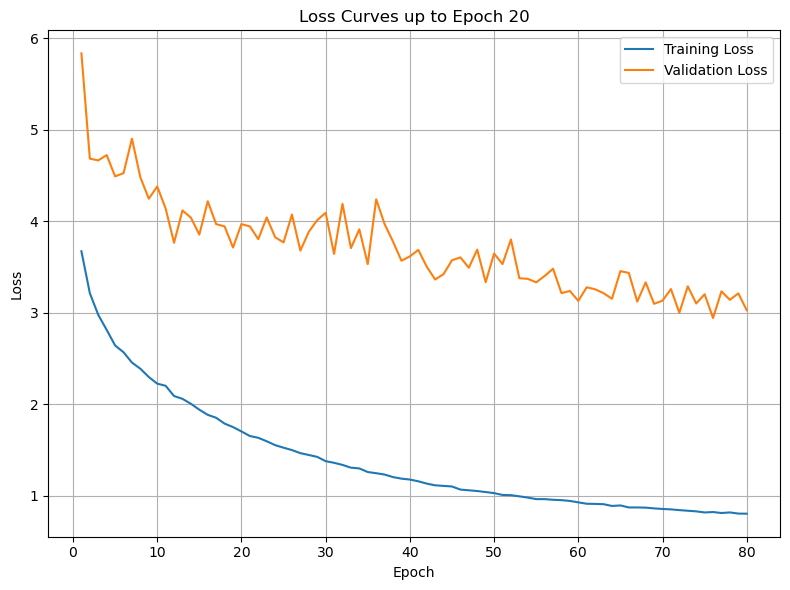

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_20.png
Epoch 21/50: Train Loss = 0.7980, Val Loss = 3.2799, Top5 Acc = 63.30%
Epoch 22/50: Train Loss = 0.7971, Val Loss = 2.9468, Top5 Acc = 71.80%
Epoch 23/50: Train Loss = 0.8052, Val Loss = 2.8046, Top5 Acc = 77.40%
Epoch 24/50: Train Loss = 0.7889, Val Loss = 2.9772, Top5 Acc = 71.60%
Epoch 25/50: Train Loss = 0.7789, Val Loss = 3.1215, Top5 Acc = 67.40%
Epoch 26/50: Train Loss = 0.7764, Val Loss = 3.2952, Top5 Acc = 61.00%
Epoch 27/50: Train Loss = 0.7689, Val Loss = 3.1433, Top5 Acc = 68.60%
Epoch 28/50: Train Loss = 0.7718, Val Loss = 2.9266, Top5 Acc = 74.60%
Epoch 29/50: Train Loss = 0.7757, Val Loss = 3.0614, Top5 Acc = 69.70%
Epoch 30/50: Train Loss = 0.7653, Val Loss = 3.2053, Top5 Acc = 64.20%


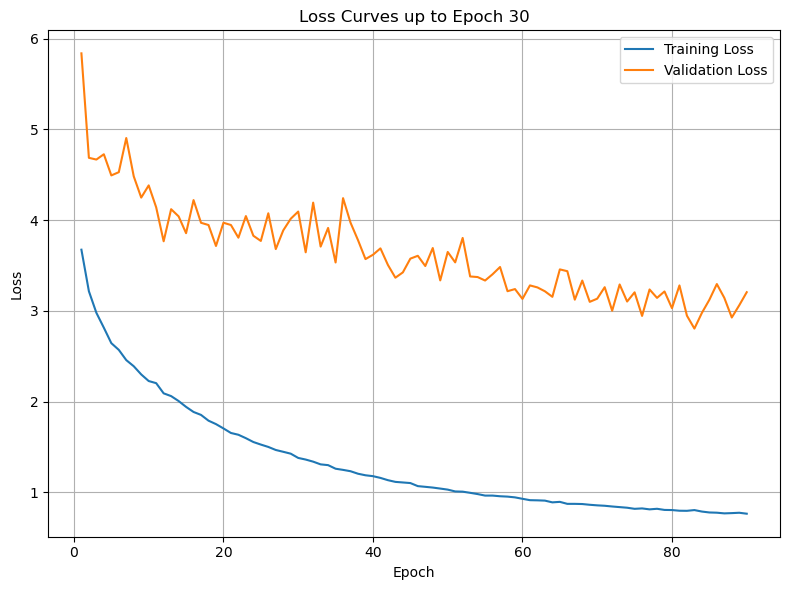

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_30.png
Epoch 31/50: Train Loss = 0.7591, Val Loss = 3.0531, Top5 Acc = 68.80%
Epoch 32/50: Train Loss = 0.7594, Val Loss = 2.8632, Top5 Acc = 75.60%
Epoch 33/50: Train Loss = 0.7578, Val Loss = 2.8622, Top5 Acc = 74.00%
Epoch 34/50: Train Loss = 0.7493, Val Loss = 3.0792, Top5 Acc = 68.50%
Epoch 35/50: Train Loss = 0.7442, Val Loss = 2.8681, Top5 Acc = 73.60%
Epoch 36/50: Train Loss = 0.7394, Val Loss = 2.9663, Top5 Acc = 70.80%
Epoch 37/50: Train Loss = 0.7443, Val Loss = 2.8109, Top5 Acc = 77.50%
Epoch 38/50: Train Loss = 0.7424, Val Loss = 3.0080, Top5 Acc = 71.70%
Epoch 39/50: Train Loss = 0.7379, Val Loss = 2.9527, Top5 Acc = 73.10%
Epoch 40/50: Train Loss = 0.7312, Val Loss = 3.2514, Top5 Acc = 64.80%


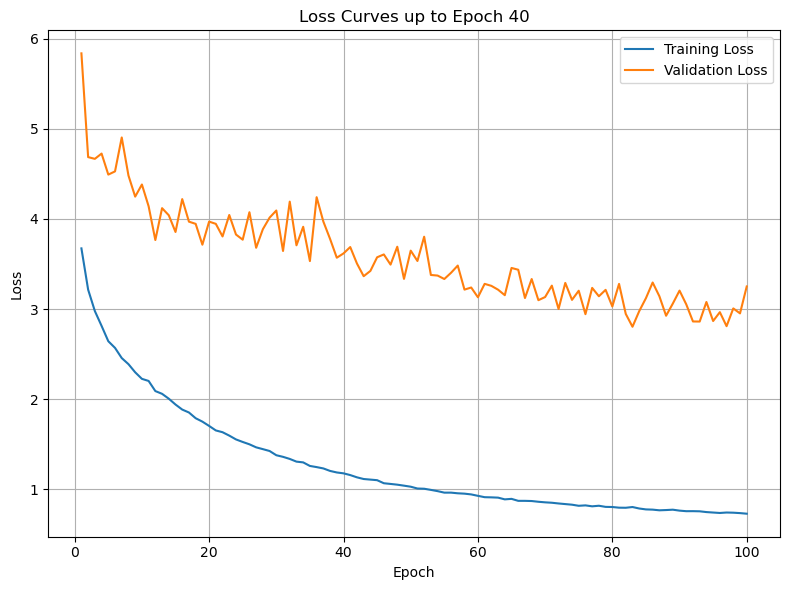

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_40.png
Epoch 41/50: Train Loss = 0.7278, Val Loss = 2.7435, Top5 Acc = 79.20%
Epoch 42/50: Train Loss = 0.7294, Val Loss = 2.8490, Top5 Acc = 76.00%
Epoch 43/50: Train Loss = 0.7161, Val Loss = 2.9221, Top5 Acc = 72.10%
Epoch 44/50: Train Loss = 0.7297, Val Loss = 3.0118, Top5 Acc = 71.90%
Epoch 45/50: Train Loss = 0.7236, Val Loss = 2.9237, Top5 Acc = 73.30%
Epoch 46/50: Train Loss = 0.7157, Val Loss = 2.8821, Top5 Acc = 76.00%
Epoch 47/50: Train Loss = 0.7114, Val Loss = 2.9837, Top5 Acc = 71.70%
Epoch 48/50: Train Loss = 0.7165, Val Loss = 2.8548, Top5 Acc = 76.80%
Epoch 49/50: Train Loss = 0.7166, Val Loss = 2.7480, Top5 Acc = 78.30%
Epoch 50/50: Train Loss = 0.7042, Val Loss = 3.0802, Top5 Acc = 71.00%


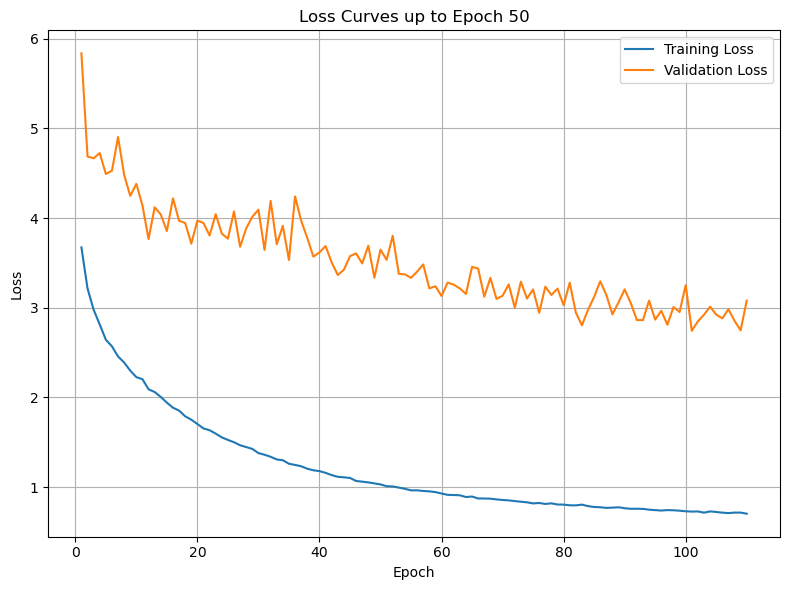

Saved loss plot to /Users/ryanaschoff/Documents/loss_plot_epoch_50.png


In [11]:
# We repeat the training loop
for epoch in range(1, num_epochs + 1):
    student_wrapper.train()
    # Generate training data for this epoch (on the fly)
    train_images, train_labels = generate_biggan_dataset(train_set_size, save_folder=None)
    train_dataset = TensorDataset(train_images, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    
    epoch_train_loss = 0.0
    num_train_batches = 0
    
    for images, labels in train_loader:
        images = images.to(device)  # images generated by BigGAN
        # For consistency with our teacher/student wrappers (which expect images in the range used by ImageNet models),
        # we assume BigGAN output is scaled appropriately. Adjust scaling if needed.
        
        # Get teacher outputs (logits and pooled features).
        with torch.no_grad():
            teacher_logits, teacher_feat2 = teacher_wrapper(images)
        
        # Get student outputs: student_wrapper returns (student_output, student_logits, student_extra)
        student_out, student_logits, student_extra = student_wrapper(images)
        
        # Compute the loss as the sum of:
        # (a) MSE loss between teacher logits and student logits, and
        # (b) MSE loss between teacher's pooled features and student's extra branch output.
        loss_logits = criterion(student_logits, teacher_logits)
        loss_feat = criterion(student_extra, teacher_feat2)
        loss = loss_logits + loss_feat
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_train_batches += 1

    avg_train_loss = epoch_train_loss / num_train_batches
    train_loss_history.append(avg_train_loss)

    # -----------------------------
    # Validation Phase: Evaluate student model performance.
    # -----------------------------
    student_wrapper.eval()
    val_loss_total = 0.0
    num_val_batches = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            teacher_logits, teacher_feat2 = teacher_wrapper(images)
            student_out, student_logits, student_extra = student_wrapper(images)
            loss_logits = criterion(student_logits, teacher_logits)
            loss_feat = criterion(student_extra, teacher_feat2)
            loss_val = loss_logits + loss_feat

            val_loss_total += loss_val.item()
            num_val_batches += 1

            # Compute the top 5 predicted class indices.
            top5_val, pred_top5 = torch.topk(student_logits, k=5, dim=1)
            # Check if the true label is among the top 5 predictions.
            for i in range(pred_top5.size(0)):
                if labels[i] in pred_top5[i]:
                    correct_top5 += 1
            total += labels.size(0)

    avg_val_loss = val_loss_total / num_val_batches
    val_loss_history.append(avg_val_loss)
    top5_accuracy = 100.0 * correct_top5 / total
    top5_accuracy_history.append(top5_accuracy)

    # Save the student model for this epoch.
    model_filename = os.path.join(os.getcwd(), f"student_epoch_{epoch+len(train_loss_history)}.pth")
    torch.save(student_wrapper.state_dict(), model_filename)

    # Print losses and validation top5 accuracy.
    print(f"Epoch {epoch}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Top5 Acc = {top5_accuracy:.2f}%")
    
    # Append losses and top5 accuracy to CSV file.
    with open(CSV_FILENAME, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([epoch, avg_train_loss, avg_val_loss, top5_accuracy])
    
    # Every 10 epochs, plot the training and validation losses.
    if epoch % 10 == 0:
        plt.figure(figsize=(8, 6))
        epochs_range = range(1, len(train_loss_history)+1)
        plt.plot(epochs_range, train_loss_history, label='Training Loss')
        plt.plot(epochs_range, val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss Curves up to Epoch {epoch}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        # Optionally, you can save the plot:
        plot_filename = os.path.join(os.getcwd(), f"loss_plot_epoch_{epoch}.png")
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved loss plot to {plot_filename}")

Since there is no more time for computation, we end the calculation here. It appears that training could still continue. Just the halfway point showed some promising results as well, so this is a very good technique to distill knowledge.